### What's in our backpack

Here's a list of functions packing up what we've learnt in the previous lesson.

In [2]:
from astropy.io import fits
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def argmax(arr):
    """Find the maximum point of a 1-d or 2-d array"""
    if len(arr.shape) == 1:
        return np.argmax(arr)
    else:
        return np.unravel_index(np.argmax(arr), arr.shape)
    
def get_data(name):
    """Get data from a FITS frame"""
    hdul = fits.open(name)
    return hdul[0].data

def get_header(name):
    """Get header from a FITS frame"""
    hdul = fits.open(name)
    return hdul[0].header

def plot(arr, title=None, argmax=None, new=True, vmin=None, vmax=None, scatter=False, selection=None, **kwargs):
    """Plot a 1-d or 2-d array"""
    if len(arr.shape) == 1: 
        plot_1d(arr, title, argmax, new, vmin, vmax, scatter=scatter, **kwargs)
    elif len(arr.shape) == 2:
        plot_2d(arr, title, argmax, new, vmin, vmax, selection=selection, **kwargs)
    else:
        pass
    
def plot_1d(arr, title=None, argmax=None, new=True, vmin=None, vmax=None, xlabel='pixel', ylabel='ADU', scatter=False, **kwargs):
    """Plot a 1-d array, possibly with its maximum highlighted"""
    if new: 
        plt.figure(figsize=(16,8))
        plt.title(title)
    if scatter:
        plt.scatter(range(len(arr)), arr, **kwargs)
    else:
        plt.plot(range(len(arr)), arr, **kwargs)
    plt.ylim(vmin, vmax)
    if argmax is not None: plt.scatter(argmax, np.max(arr), color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot_2d(arr, title=None, argmax=None, new=True, vmin=None, vmax=None, xlabel='x pixel', ylabel='y pixel', selection=None,
            **kwargs):
    """Plot a 2-d array, possibly with its maximum highlighted"""
    if new: 
        plt.figure(figsize=(16,8))
        plt.title(title)
    plt.imshow(arr, vmin=vmin, vmax=vmax, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if selection is not None:
        rect = patches.Rectangle(selection['xy'], selection['width'], selection['height'], edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    if argmax is not None: plt.scatter(argmax[1], argmax[0], color='r')
    
def plot_medrange(arr, title=None, hwid=200, argmax=None, new=True, **kwargs):
    """Same as `plot`, but with a colorbar centered around the median value"""
    plot(arr, title, argmax, new, np.nanmedian(arr)-hwid, np.nanmedian(arr)+hwid, **kwargs)
    
def plot_sequence(seq, plot_func, **kwargs):
    """Plot a sequence of arrays in the same window"""
    for i, arr in enumerate(seq):
        plot_func(arr, **kwargs)
        plt.text(x=50, y=50, s=i, color='black', ha='center', va='center', fontsize='xx-large')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
        
def plot_time_series(t, f, title=None, new=True, ylog=False, xlabel='time', ylabel='Flux (ph)', **kwargs):
    """Plot a time series"""
    if new: 
        plt.figure(figsize=(16,8))
        plt.title(title)
    if ylog:
        plt.semilogy(t, f, **kwargs)
    else:
        plt.plot(t, f, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Let's also load the science, bias, and flat frames.  
We use ```flip``` to rotate science frames by 180 degrees, so the North direction is up.

In [3]:
sci_names = np.array(['/Users/guido/Dropbox/lectures/2019/SZ_Lyn/Autosave Image -%03i.fit' % i for i in range(1,211)])
sci = np.array([np.flip(get_data(n)) for n in sci_names])
sci_hdr = np.array([get_header(n) for n in sci_names])
bias = np.array([get_data('/Users/guido/Dropbox/lectures/2019/bias/CCD Image %i.fit' % i) for i in range(9,17)])
flat = np.array([get_data('/Users/guido/Dropbox/lectures/2019/flat/CCD Image %i.fit' % i) for i in range(8,16)])

Note that science frames have been shifted to match world coordinates and trimmed to fit within the same shape: for these reasons, there are frequently empty strips of pixels along the sides.  
Also, note that from science frame 24 onwards the bright pixel column on the right of the detector flips to the opposite side (the frames were taken with the detector rotated by 180 degrees).  
We will take both facts into account when removing the bias and the flat.

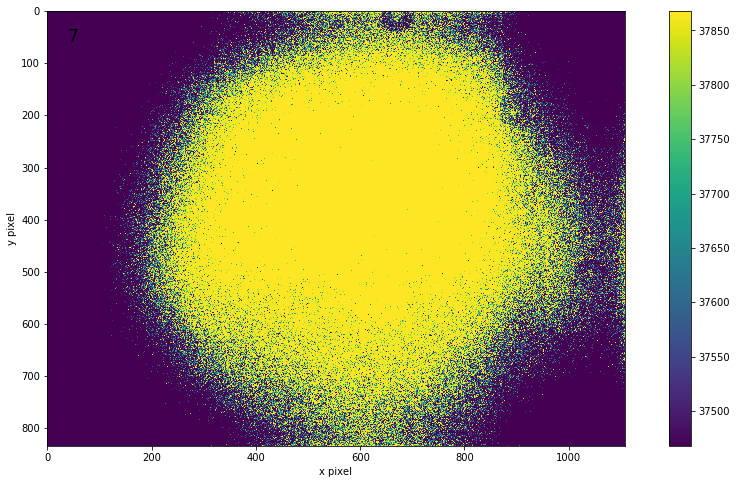

In [4]:
plot_sequence(sci, plot_medrange)
plot_sequence(bias, plot_medrange)
plot_sequence(flat, plot_medrange)

Let's create an array of 2-tuples denoting how much each science frames was shifted along rows and columns:

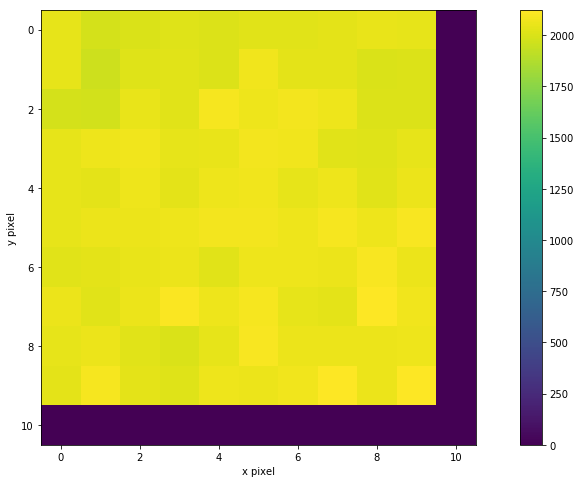

In [5]:
zeros = np.where(sci[100]==0)
null_rows = np.array([np.append(np.where(np.sum(s, axis=1)==0), 0) for s in sci])
null_cols = np.array([np.append(np.where(np.sum(s, axis=0)==0), 0) for s in sci])
shift_rows = np.array([(len(n)-1)*(-1)**(n[0]!=0) for n in null_rows])
shift_cols = np.array([(len(n)-1)*(-1)**(n[0]!=0) for n in null_cols])
shift = np.array(list(zip(shift_rows, shift_cols)))

i=1
if shift[i][0] > 0 and shift[i][1] > 0:
    plot(sci[i][:shift[i][1]+10, :shift[i][0]+10])
if shift[i][0] < 0 and shift[i][1] > 0:
    plot(sci[i][shift[i][0]-10:, :shift[i][1]+10])
if shift[i][0] > 0 and shift[i][1] < 0:
    plot(sci[i][:shift[i][0]+10, shift[i][1]-10:])
if shift[i][0] < 0 and shift[i][1] < 0:
    plot(sci[i][shift[i][0]-10:, shift[i][1]-10:])
plt.show()

### The master of all bias

A **master bias** is obtained by averaging several bias frames:

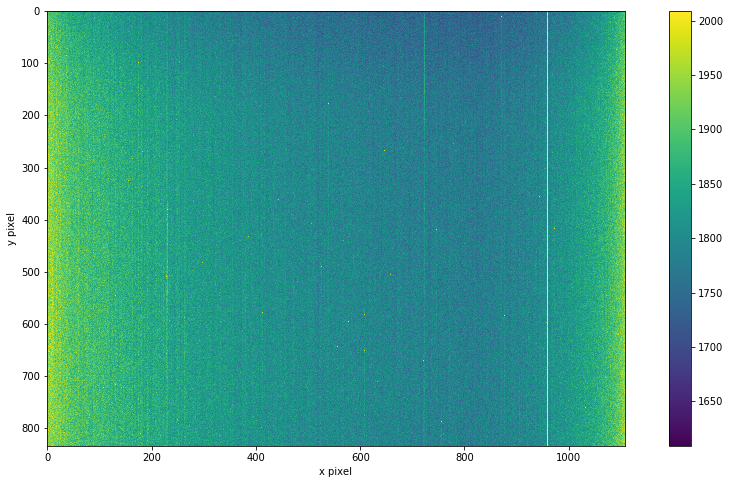

In [6]:
bias_med = np.median(bias, axis=0)
plot_medrange(bias_med)

In this case, the median is not a good master bias because the individual bias frames are not so similar to each other; let's compare e.g. the median along the rows

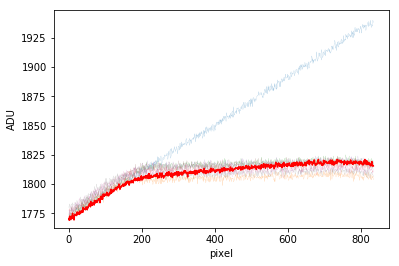

In [7]:
for b in bias:
    plot(np.median(b, axis=1), new=False, linewidth=0.1)
plot(np.median(bias_med, axis=1), title='Median bias along rows', new=False, color='red')
plt.show()

We can use a limited region where the bias is flat (in the frame where it is) to estimate the read-out noise from the standard deviation of the bias values. Note that we must convert counts into photons using the **gain** of the detector:

In [8]:
slice = np.s_[250:300, 250:300]

bias_reg = np.array([b[slice] for b in bias[1:]])
bias_mean = np.array([np.mean(b) for b in bias_reg])
bias_std = np.array([np.std(b) for b in bias_reg])

gain = 0.6  # e-/counts
ron = np.mean(bias_std)*gain
ron

28.816228996340406

We can check that the histogram of the values is well represented by a gaussian function:

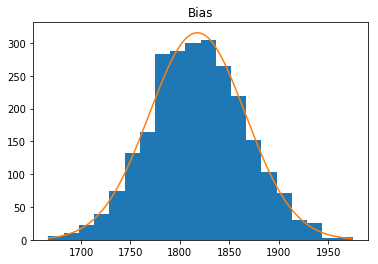

In [9]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x-mu, 2.) / (2*np.power(sig, 2.)))

def hist(arr, bins=None, range=None, title=None, new=True):
    """Plot histogram"""
    if new: plt.figure()
    n, bins, _ = plt.hist(safe(arr).ravel(), bins, range)
    plt.title(title)
    return n, bins

def safe(arr):
    """Reject NaNs"""
    return arr[~np.isnan(arr)]

i = 0
n, bins = hist(bias_reg[i], bins=20, title='Bias', new=False)
x = np.arange(bins[0], bins[-1])
g = gaussian(x, bias_mean[i], bias_std[i])
plt.plot(x, g*np.sum(n)/np.sum(g)*len(g)/len(n))
plt.show()

We can remove the master bias from the science frame, even if it's not perfect.  
We must remember, to shift the master bias to match the position of science frames after realignment. We use the method ```roll```, which shifts the values and fills the empty regions with the values that went out of the borders.  
We also use ```flip``` to rotate the master bias by 180 degrees from frame 24 onwards.

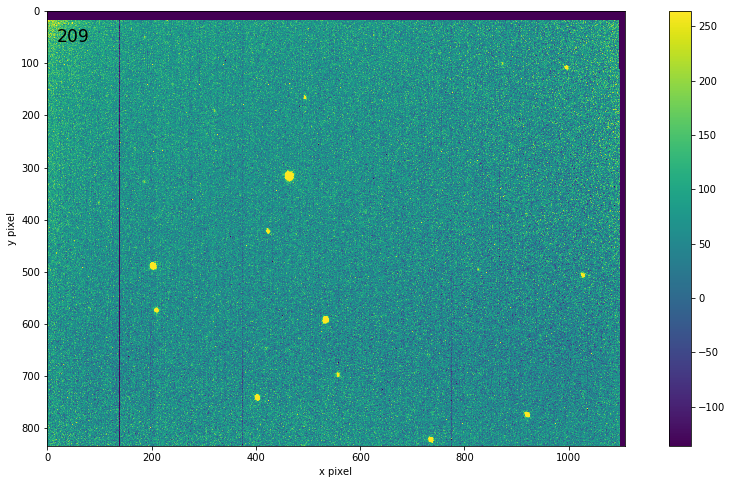

In [10]:
bias_shift_1 = np.array([np.roll(np.roll(bias_med, s[0], axis=0), s[1], axis=1) for s in shift[:24]])
bias_shift_2 = np.array([np.roll(np.roll(np.flip(bias_med), s[0], axis=0), s[1], axis=1) for s in shift[24:]])
bias_shift = np.append(bias_shift_1, bias_shift_2, axis=0)

sci_nobias = sci-bias_shift
plot_sequence(sci_nobias, plot_medrange)

The removal is effective in the x direction, but not in the y direction. This may happen when the bias is not stable (the CCD is not so high-quality). We don't care about this for now, as any bias residual will be removed together with the background later.

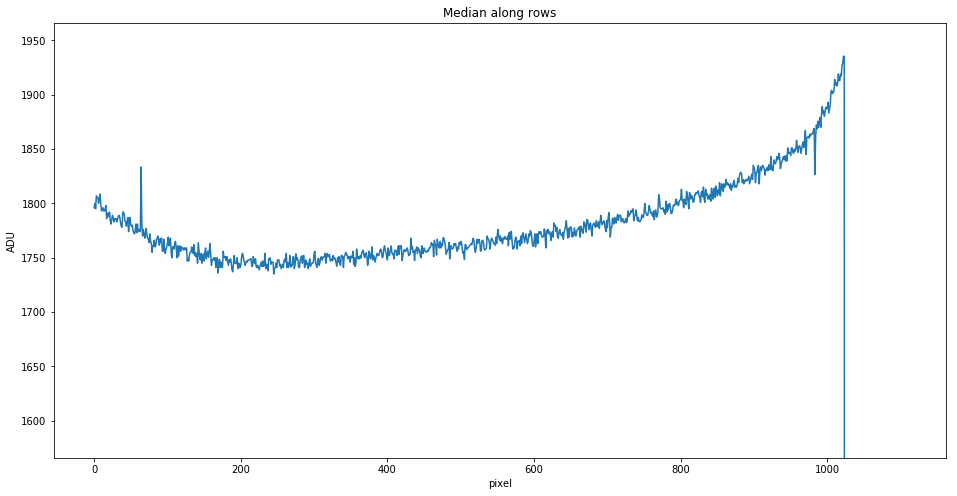

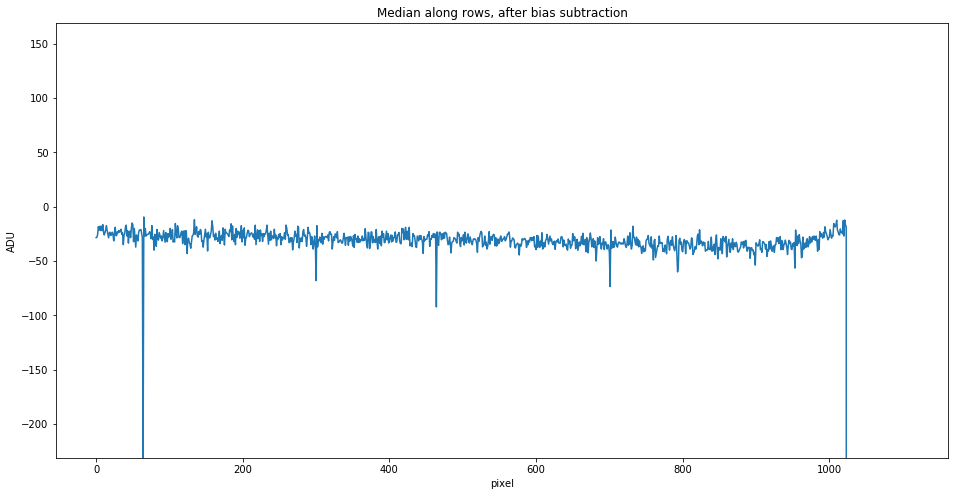

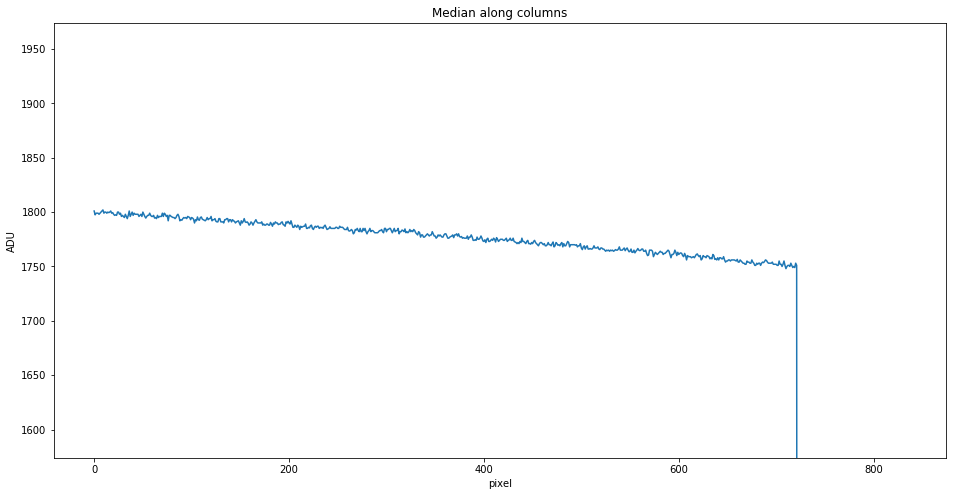

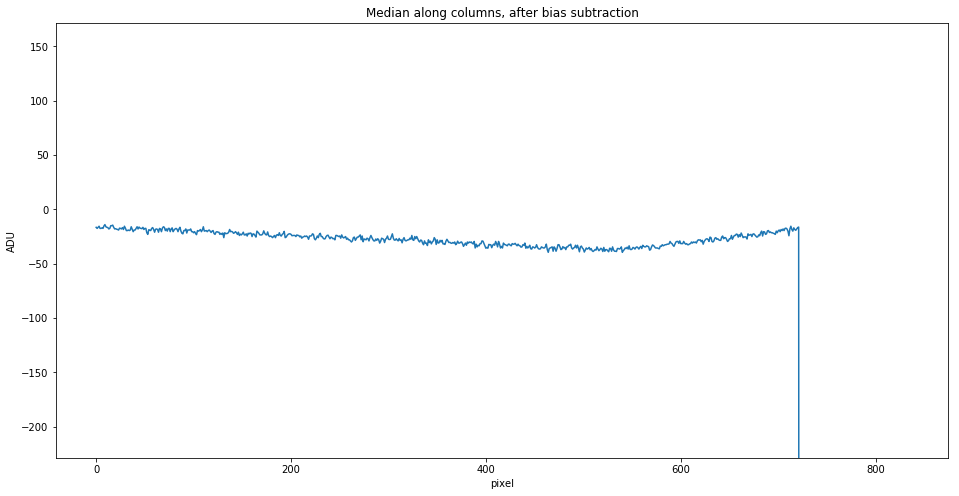

In [11]:
i = 40
plot_medrange(np.median(sci[i], axis=0), title='Median along rows')
plot_medrange(np.median(sci_nobias[i], axis=0), title='Median along rows, after bias subtraction')
plot_medrange(np.median(sci[i], axis=1), title='Median along columns')
plot_medrange(np.median(sci_nobias[i], axis=1), title='Median along columns, after bias subtraction')
plt.show()

### Make my field flat

Again, we collect and average a set of flat frames to create a **master flat**. The master bias is subtracted to the individual flat frames prior to averaging. The master flat is then normalized:

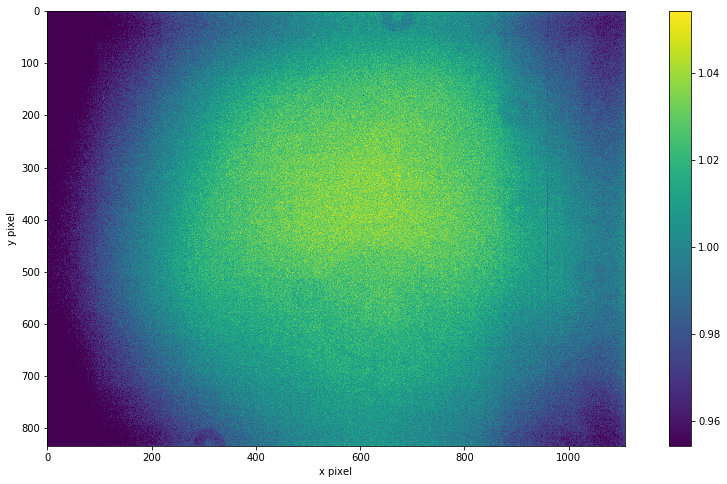

In [12]:
flat_med = np.median(flat-bias_med, axis=0)
flat_norm = flat_med/np.mean(flat_med)
plot_medrange(flat_norm, hwid=0.05)
plt.show()

Flat-fielding is performed by dividing the debiased science frames by the master flat.  
As with the master bias, we shift the master dar to match the position of the science frames and we rotate it by 180 degrees from frame 24 onwards.

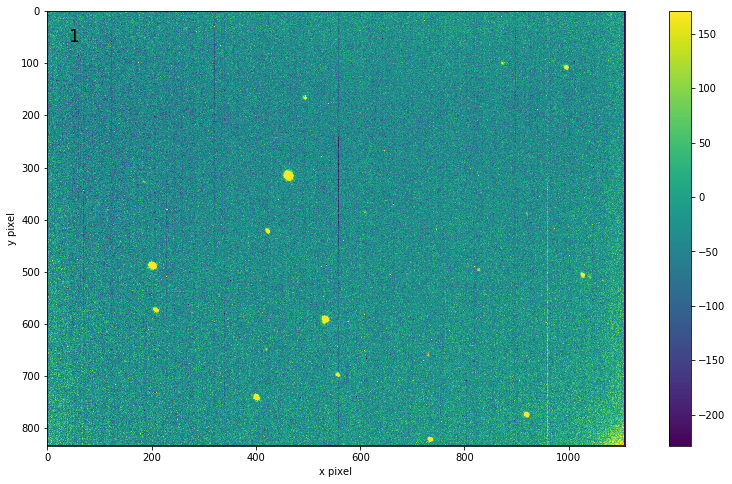

In [ ]:
flat_shift_1 = np.array([np.roll(np.roll(flat_norm, s[0], axis=0), s[1], axis=1) for s in shift[:24]])
flat_shift_2 = np.array([np.roll(np.roll(np.flip(flat_norm), s[0], axis=0), s[1], axis=1) for s in shift[24:]])
flat_shift = np.append(flat_shift_1, flat_shift_2, axis=0)

sci_red = sci_nobias/flat_shift
plot_sequence(sci_red, plot_medrange)

Let's make a function to perform the full reduction:

In [ ]:
def prepare(master):
    master_shift_1 = np.array([np.roll(np.roll(master, s[0], axis=0), s[1], axis=1) for s in shift[:24]])
    master_shift_2 = np.array([np.roll(np.roll(np.flip(master), s[0], axis=0), s[1], axis=1) for s in shift[24:]])
    return np.append(master_shift_1, master_shift_2, axis=0)

def redux(sci, bias_prep, flat_prep):
    return (sci-bias_prep)/flat_prep   

bias_prep = prepare(bias_med)
flat_prep = prepare(flat_norm)
sci_red = redux(sci, bias_prep, flat_prep)

### Counting photons

Let's focus on the neighborhood of our target:

In [ ]:
sz_lyn_reg = np.array([s[250:380,400:530] for s in sci_red])
sz_lyn_am = np.array([argmax(s) for s in sz_lyn_reg])

i = 0
plot_medrange(sci_red[i], selection={'xy': (400,250), 'width': 130, 'height': 130})
plot(sz_lyn_reg[i], argmax=sz_lyn_am[i])
plot_medrange(sz_lyn_reg[i], argmax=sz_lyn_am[i])
plt.show()

Let's separate target and background with a square mask. First, we use ```ogrid``` to center the indices of the image at the maximum. Then, we select the indices within a square. 

In [ ]:
def mask_sq(sci_red, am, hwidth=12):
    shape = sci_red.shape
    y, x = np.ogrid[-am[0]:shape[0]-am[0], -am[1]:shape[1]-am[1]]
    return np.logical_and(np.abs(x) < hwidth, np.abs(y) < hwidth)

inside = np.copy(sz_lyn_reg)  # `copy` creates new objects
outside = np.copy(sz_lyn_reg)
for i, o, s, a in zip(inside, outside, sz_lyn_reg, sz_lyn_am):
    mask = mask_sq(s, a)
    i[~mask] = np.nan
    o[mask] = np.nan
    
i = 0
plot(sz_lyn_reg[i], argmax=sz_lyn_am[i])
plot(inside[i], argmax=sz_lyn_am[i])
plot_medrange(outside[i])
plt.show()

The histograms of ```inside``` and ```outside``` are revealing:

In [ ]:
i = 0
hist(inside[i], bins=20, title='Inside')
hist(outside[i], bins=20, title='Outside')
plt.show()

The ```outside``` image is flat enough: its median can be used as a reliable estimation of the background.

In [ ]:
med_row = np.nanmedian(outside, axis=1)
med_col = np.nanmedian(outside, axis=2)
bkg = np.array([np.nanmedian(o) for o in outside])
bkg_std = np.array([np.nanstd(o) for o in outside])

i = 120
plt.figure(figsize=(16,8))
for r in outside[i]:
    plot(r, scatter=True, vmin=bkg[i]-5*ron, vmax=bkg[i]+5*ron, new=False, s=1, title='Background')
plt.axhline(bkg[i], c='red', linewidth=2)
plt.axhline(bkg[i]+bkg_std[i], c='red', linewidth=1)
plt.axhline(bkg[i]-bkg_std[i], c='red', linewidth=1)
plt.show()

We can finally count photons on the background-subtracted image. Note that we again convert counts into photons using the gain. The results can be plotted as a function of the Julian date:

In [ ]:
sub = np.array([i-b for i,b in zip(inside, bkg)]) 
sz_lyn_signal = np.array([np.nansum(s)*gain for s in sub])
jd = np.array([h['JD-HELIO'] for h in sci_hdr])
plot_time_series(jd, sz_lyn_signal, xlabel='time (JD)', title='SZ Lyn')
plt.show()

Let's summarize with a new function what we've done so far. We can also roughly estimate the signal-to-noise ratio (**SNR**), assuming that dark current is negligible): 

In [ ]:
def phot(sci_red, mask_func, am=None, gain=0.6, ron=29.0, **kwargs):
    inside = np.copy(sci_red)  
    outside = np.copy(sci_red)
    if am is None:
        am = np.array([argmax(s) for s in sci_red])
    ron2 = np.array([])
    for i, o, s, a in zip(inside, outside, sci_red, am):
        mask = mask_func(s, a, **kwargs)
        ron2 = np.append(ron2, ron**2*np.sum(mask))
        i[~mask] = np.nan
        o[mask] = np.nan
    bkg = np.array([np.nanmedian(o) for o in outside])
    bkg_noise = np.array([np.nanstd(o) for o in outside])
    sub = np.array([i-b for i,b in zip(inside, bkg)]) 
    signal = np.array([np.nansum(s)*gain for s in sub])
    snr = signal / np.sqrt(signal+2*bkg_noise+2*ron2)  # Very very roughly
    return signal, bkg_noise, ron2, snr

sz_lyn_signal_sq, sz_lyn_bkg_sq, sz_lyn_ron2_sq, sz_lyn_snr_sq = phot(sz_lyn_reg, mask_sq, ron=ron)
plot_time_series(jd, sz_lyn_signal_sq, ylog=True, xlabel='time (JD)')
plot_time_series(jd, sz_lyn_bkg_sq, ylog=True, xlabel='time (JD)', new=False)
plot_time_series(jd, sz_lyn_ron2_sq, xlabel='time (JD)', new=False, title='SZ Lyn')
plot_time_series(jd, sz_lyn_snr_sq, xlabel='time (JD)', ylabel='SNR', title='SZ Lyn')
plt.show()

Remember that we used a square mask? Let's use a more suited circular mask, and shift the center a little:

In [ ]:
def mask_circ(sci_red, am, rad=13):
    shape = sci_red.shape
    y, x = np.ogrid[-am[0]:shape[0]-am[0], -am[1]:shape[1]-am[1]]
    return x**2 + y**2 < rad**2

inside = np.copy(sz_lyn_reg)  
outside = np.copy(sz_lyn_reg)
for i, o, s, a in zip(inside, outside, sz_lyn_reg, sz_lyn_am):
    mask = mask_circ(s, a)
    i[~mask] = np.nan
    o[mask] = np.nan

i = 0
plot(inside[i], argmax=sz_lyn_am[i])
plot_medrange(outside[i])
plt.show()

Any difference in the SNR?

In [ ]:
sz_lyn_signal_circ, sz_lyn_bkg_circ, sz_lyn_ron2_circ, sz_lyn_snr_circ = phot(sz_lyn_reg, mask_circ)
plot_time_series(jd, sz_lyn_bkg_sq, xlabel='time (JD)')
plot_time_series(jd, sz_lyn_bkg_circ, xlabel='time (JD)', new=False, title='Background')
plot_time_series(jd, sz_lyn_ron2_sq, xlabel='time (JD)')
plot_time_series(jd, sz_lyn_ron2_circ, xlabel='time (JD)', new=False, title='RON squared')
plot_time_series(jd, sz_lyn_snr_sq, xlabel='time (JD)')
plot_time_series(jd, sz_lyn_snr_circ, xlabel='time (JD)', new=False, title='SNR')
plt.show()

### Quick-and-dirty flux calibration

You can see that the light curve has a trend. Let's check a neighbouring star to see what's going on:

In [ ]:
bjr_415_reg = np.array([s[420:550,140:270] for s in sci_red])
bjr_415_am = np.array([argmax(s) for s in bjr_415_reg])
bjr_415_signal_circ, _, _, _ = phot(bjr_415_reg, mask_circ)

i = 0
plot_medrange(sci_red[i], selection={'xy': (140,420), 'width': 130, 'height': 130})
plot(bjr_415_reg[i], argmax=bjr_415_am[i])
plot_time_series(jd, bjr_415_signal_circ, xlabel='time (JD)', title='BJR 415')
plt.show()

We can fit the trend of this star:

In [ ]:
from scipy.interpolate import UnivariateSpline as us

bjr_415_spline = us(jd, bjr_415_signal_circ)
bjr_415_spline.set_smoothing_factor(5e8)
bjr_415_signal_fit = bjr_415_spline(jd)

plot_time_series(jd, bjr_415_signal_circ, xlabel='time (JD)', title='BJR 415')
plot_time_series(jd, bjr_415_signal_fit, xlabel='time (JD)', new=False)

Let's do the same for another star:

In [ ]:
bjr_416_reg = np.array([s[520:650,470:600] for s in sci_red])
bjr_416_am = np.array([argmax(s) for s in bjr_416_reg])
bjr_416_am[178:] = (70, 63)  # There's a moving object on the sub-image! Must correct the maximum or the star isn't found
bjr_416_signal_circ, _, _, _ = phot(bjr_416_reg, mask_circ, am=bjr_416_am)
bjr_416_spline = us(jd, bjr_416_signal_circ)
bjr_416_spline.set_smoothing_factor(3e8)
bjr_416_signal_fit = bjr_416_spline(jd)

i = 178
plot_medrange(sci_red[i], selection={'xy': (470,520), 'width': 130, 'height': 130})
plot(bjr_416_reg[i], argmax=bjr_416_am[i])
plot_time_series(jd, bjr_416_signal_circ, xlabel='time (JD)', title='BJR 416')
plot_time_series(jd, bjr_416_signal_fit, xlabel='time (JD)', new=False)
plt.show()

We can put the stars together to compute an average reference:

In [ ]:
ref_norm = np.mean([bjr_415_signal_circ/np.mean(bjr_415_signal_circ), bjr_416_signal_circ/np.mean(bjr_416_signal_circ)], axis=0)
ref_spline = us(jd, ref_norm)
ref_spline.set_smoothing_factor(1.5e-2)
ref = ref_spline(jd)

sz_lyn_signal_norm = sz_lyn_signal_circ/ref
bjr_415_signal_norm = bjr_415_signal_circ/ref
bjr_416_signal_norm = bjr_416_signal_circ/ref
plot_time_series(jd, ref_norm, xlabel='time (JD)', title='Average reference')
plot_time_series(jd, ref, xlabel='time (JD)', new=False)

plot_time_series(jd, sz_lyn_signal_norm, xlabel='time (JD)', title='SZ Lyn, BJR 415, BJR 416')
plot_time_series(jd, bjr_415_signal_norm, xlabel='time (JD)', new=False)
plot_time_series(jd, bjr_416_signal_norm, xlabel='time (JD)', new=False)
plt.show()

Magnitudes are easily computed from the mean counts of the two reference stars:

In [ ]:
def V_ext(signal, signal_ref, V_ref):
    return V_ref - 2.5*(np.log10(signal)-np.log10(signal_ref))

bjr_415_V = 10.924
bjr_416_V = 11.456
bjr_415_mean = np.mean(bjr_415_signal_norm)
bjr_416_mean = np.mean(bjr_416_signal_norm)

bjr_415_V_ext = V_ext(bjr_415_signal_norm, bjr_415_mean, bjr_415_V)
bjr_416_V_ext = V_ext(bjr_416_signal_norm, bjr_415_mean, bjr_415_V)

sz_lyn_V_ext = V_ext(sz_lyn_signal_norm, bjr_415_mean, bjr_415_V)

plot_time_series(jd, sz_lyn_V_ext, xlabel='time (JD)', ylabel='V magnitude', title='SZ Lyn, BJR 415, BJR 416')
plot_time_series(jd, bjr_415_V_ext, xlabel='time (JD)', ylabel='V magnitude', new=False)
plot_time_series(jd, bjr_416_V_ext, xlabel='time (JD)', ylabel='V magnitude', new=False)
plot_time_series(jd, [bjr_416_V]*len(jd), xlabel='time (JD)', ylabel='V magnitude', new=False)
plt.ylim(11.6, 9)
plt.show()

If we shift the curve by one period, we see that we've done a pretty decent job:

In [ ]:
period = 0.12053492
plot_time_series(jd, sz_lyn_V_ext, xlabel='time (JD)', ylabel='V magnitude', title='SZ Lyn')
plot_time_series(jd+period, sz_lyn_V_ext, xlabel='time (JD)', ylabel='V magnitude', new=False)
plt.ylim(10, 9)
plt.show()